In [364]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from uuid import uuid4
from collections import defaultdict
from matplotlib import colors

**NOTES**

1. In order to use the same set of random numbers go for `np.random.seed(0)`;
2. Points are defined as tuples: (x,y);
3. The option to play with alpha parameter, varying it how you need: `plt.plot(p[0], p[1], 'o', color=color, alpha = 0.3 + 0.7/(data_idx+1))`

In [365]:
class Rectangle:
    '''We'll use rectangle as a canvas, though canvas is a broader term
    TODO:
    - maybe it's good to add a starting point, as it may not always be (0,0) -- maybe useful for drawing many rectangles ✅;
    - maybe worth renaming to Rectangle ✅;

    '''
    def __init__(
            self,
            width: int,
            height: int,
            init_point: tuple[int] = (0,0),
            margin: int = 10
    ):
        self.w = width
        self.h = height
        self.margin = margin
        self.critical_points = [
            (init_point[0], init_point[1]),
            (init_point[0], height),
            (width, height),
            (width, init_point[1])
        ]
        self.critical_all_x = [p[0] for p in self.critical_points] + [self.critical_points[0][0]] # the last point is init point: to properly draw the bottomw side in matplotlib
        self.critical_all_y = [p[1] for p in self.critical_points] + [self.critical_points[0][1]]

    def random_point_by_side_idx(
            self,
            side_number: int,
            margin: int = None,
    ) -> tuple[float]:
        '''1st side is left side, 2nd is the horizontal top, 3rd is vertical right side, 4th is horizontal bottom
        TODO:
        - the random point may not be an integer, but a float. We can add random fraction [0-1] to the result ✅
        - The may be some margin, so we don't pick the corners ✅
        - decide if the margin should be made on init ❌
        - test the function ✅
        '''
        if not margin:
            margin = self.margin

        preset = {
            1: (0, np.random.rand() * (self.h - margin*2) + margin),
            2: (np.random.rand() * (self.w - margin*2) + margin, self.h),
            3: (self.w, np.random.rand() * (self.h - margin*2) + margin),
            4: (np.random.rand() * (self.w - margin*2) + margin, 0)
        }

        return preset[side_number]
    
    @property
    def two_random_points_on_sides(self) -> list[tuple]:
        '''Two random points must be on different sides of rectangle in order to be able to draw a line between them'''
        side_idx = [1,2,3,4]
        random_side_pair = np.random.choice(side_idx, size = 2, replace=False)
        if random_side_pair[1] == random_side_pair[0]:
            raise ValueError(f'Sides should not be the same: {random_side_pair}')
        
        point_a = self.random_point_by_side_idx(random_side_pair[0])
        point_b = self.random_point_by_side_idx(random_side_pair[1])

        return (point_a, point_b)
    
    def get_n_num_of_random_two_points(self, num_lines: int):
        list_of_two_points = []
        for _ in range(num_lines):
            list_of_two_points.append(self.two_random_points_on_sides)
        
        return list_of_two_points
    
    def __repr__(self):
        return f'---RECTANGLE OBJECT---\n{self.critical_points}. \nAll-x: {self.critical_all_x}.\nAll-y: {self.critical_all_y}'


In [366]:
w = 800
h = 600
# np.random.seed(0)
rect = Rectangle(w, h, init_point=(0,0), margin=10)
print(rect.two_random_points_on_sides)
rect

((0, 433.4529024322605), (777.8190911509383, 0))


---RECTANGLE OBJECT---
[(0, 0), (0, 600), (800, 600), (800, 0)]. 
All-x: [0, 0, 800, 800, 0].
All-y: [0, 600, 600, 0, 0]

In [394]:
class Line:
    '''We can define a line either by giving an input of coefficients a and b, as an equation y = ax + b.
    Or we can define the line if we have two points tha create this line, as only one line can cross two points simulatneously.
    TODO:
     - If we are provided both with a,b and two-points, we need to be sure that these are ok and calculated properly ✅
     - In any case we should end up with a/b coefs, that are most important for further calculations ✅
    '''
    def __init__(
            self,
            a: float = None,
            b: float = None,
            two_points: tuple[tuple] = None
    ):
        # Checking the inputs
        if not (a and b) and not two_points:
            raise ValueError('You have not provided enough information')
        
        if a and b and two_points:
            a_check, b_check = self.get_line_coefs_given_two_points(two_points)
            if a != a_check or b != b_check:
                raise ValueError('Provided data is not correct. Two points dont match a,b coefs.')
        
        # Adding all the important attributes
        self.id = str(uuid4())

        if not two_points:
            self.line_type = 'slope'
            self.a = a
            self.b = b
            self.two_points = None
            return 

        self.two_points = two_points
        self.start, self.end = self.get_start_end_point()
        point_one = two_points[0]
        point_two = two_points[1]
        
        if point_one[0] == point_two[0]:
            self.line_type = 'vertical'
            self.a = 'undefined'
            self.b = 'undefined'
        
        elif point_one[1] == point_two[1]:
            self.line_type = 'horizontal'
            self.a = 0
            self.b = point_one[1]
        
        else:
            self.line_type = 'slope'
            self.a, self.b = self.get_line_coefs_given_two_points(two_points)
        
        self._get_angle()

    
    def get_line_coefs_given_two_points(self, two_points: tuple[tuple]) -> tuple[float]:
        '''We are given two points (x,y) & (x2, y2). We need to identify the line equation for them: y = ax + b'''
        point_one = two_points[0]
        point_two = two_points[1]

        a = (point_two[1] - point_one[1]) / (point_two[0] - point_one[0])
        b = point_one[1] - a * point_one[0]

        # Checking the calculations
        check_val_1 = a*point_one[0] + b - point_one[1]
        check_val_2 = a*point_two[0] + b - point_two[1]
        if np.abs(check_val_1) > 0.0001 or np.abs(check_val_2) > 0.0001:
            raise ValueError(f'Some error. Check1: {check_val_1}. Check2: {check_val_2}')
        
        return (a, b)
    
    
    def _get_angle(self):
        if self.line_type == 'vertical':
            self.angle_rad = np.pi / 2
            self.angle_deg = 90
        elif self.line_type == 'horizontal':
            self.angle_rad = 0
            self.angle_deg = 0
        else:
            self.angle_rad = np.arctan(self.a)
            self.angle_deg = np.rad2deg(self.angle_rad)
    
    def get_start_end_point(self) -> tuple:
        point1, point2 = self.two_points
        if point1[0] < point2[0]:
            return (point1, point2)
        return (point2, point1)

    def __str__(self):
        return f'''
        ---LINE OBJECT---
        Line type: {self.line_type}.
        a: {self.a}.
        b: {self.b}.
        start: {self.start}
        end: {self.end}
        Angle RAD: {np.round(self.angle_rad,2)}.
        Angle DEG: {self.angle_deg}
        ID: {self.id}'''
    
    def __repr__(self):
        return f'''{self.id}'''

In [397]:
my_line = Line(two_points=((5,6), (10,10)))
my_line2 = Line(two_points=((0,3), (10,7)))
print(my_line)

my_line == my_line

my_dict = {}
my_dict[my_line] = [my_line2]
my_dict[my_line2] = [my_line]


        ---LINE OBJECT---
        Line type: slope.
        a: 0.8.
        b: 2.0.
        start: (5, 6)
        end: (10, 10)
        Angle RAD: 0.67.
        Angle DEG: 38.659808254090095
        ID: b8e613c2-abee-4ed5-8720-e87368474d64


In [452]:
class Intersection:
    '''Intersection class will help us dealing with line intersections. Getting all the possible pairs of lines.
    Finding intersection points and getting all the intersection points for a given line'''
    def __init__(self, lines_set: list[Line], w: int, h: int, init_point: tuple[int] = (0,0)):
        self.lines_set = lines_set
        self.pairs = list(combinations(lines_set, r=2))
        self.w = w
        self.h = h
        self.init_point = init_point
        self.unique_intersection_points = self.get_unique_intersections()
        self.intersections = self.get_intersections_by_lines()
        self.ordered_intersections_coords = {line: list(self.intersections[line].values()) for line in self.intersections}
        self.ordered_intersections_line_keys = {line: list(self.intersections[line].keys()) for line in self.intersections}

        return
    
    def get_intersection_point_of_two_lines(
        self,
        line_one: Line,
        line_two: Line,
    ) -> tuple[float]:
        
        try:
            x = (line_two.b - line_one.b) / (line_one.a - line_two.a)
            y = x * line_one.a + line_one.b
        except (ValueError, ZeroDivisionError):
            print(f'Lines are not interseting: {line_one}. {line_two}')
            return None

        check_val_1 = line_one.a * x + line_one.b - y
        check_val_2 = line_two.a * x + line_two.b - y

        if np.abs(check_val_1) > 0.0001 or np.abs(check_val_2) > 0.0001:
            raise ValueError(f'Some error. Check1: {check_val_1}. Check2: {check_val_2}')
        
        return (x, y)
    
    def get_unique_intersections(self) -> list[tuple]:
        '''This function is needed to draw unique circles on the points of intersection. Points should not be repeated and overlapped'''
        unique_intersection_points = []
        for line1, line2 in self.pairs:
            inter_point = self.get_intersection_point_of_two_lines(line1, line2)
            x = inter_point[0]
            y = inter_point[1]

            if x < 0 or x > self.w or y < 0 or y > h:
                continue
            
            unique_intersection_points.append(inter_point)
    
        return unique_intersection_points
    
    def get_intersections_by_lines(self) -> defaultdict[list]:
        '''This function is needed to draw a random path on the lines. Each line has the info about the lines with which it crosses.'''
        intersection_dict = defaultdict(dict)
        for line1, line2 in self.pairs:
            intersect_point = self.get_intersection_point_of_two_lines(line1, line2)
            if not intersect_point:
                continue
            inter_x = intersect_point[0]
            inter_y = intersect_point[1]
            
            if inter_x < self.init_point[0] or inter_x > w or inter_y < self.init_point[1] or inter_y > h:
                continue
            
            intersection_dict[line1][line2] = intersect_point
            intersection_dict[line2][line1] = intersect_point

        
        for line in intersection_dict.keys():
            intersection_dict[line] = dict(sorted(intersection_dict[line].items(), key=lambda item: item[1][0]))
            intersection_dict[line]['start'] = line.start
            intersection_dict[line] = dict(sorted(intersection_dict[line].items(), key=lambda item: -item[1][0] if item[0] == 'start' else item[1][0]))
            intersection_dict[line]['end'] = line.end

        return intersection_dict

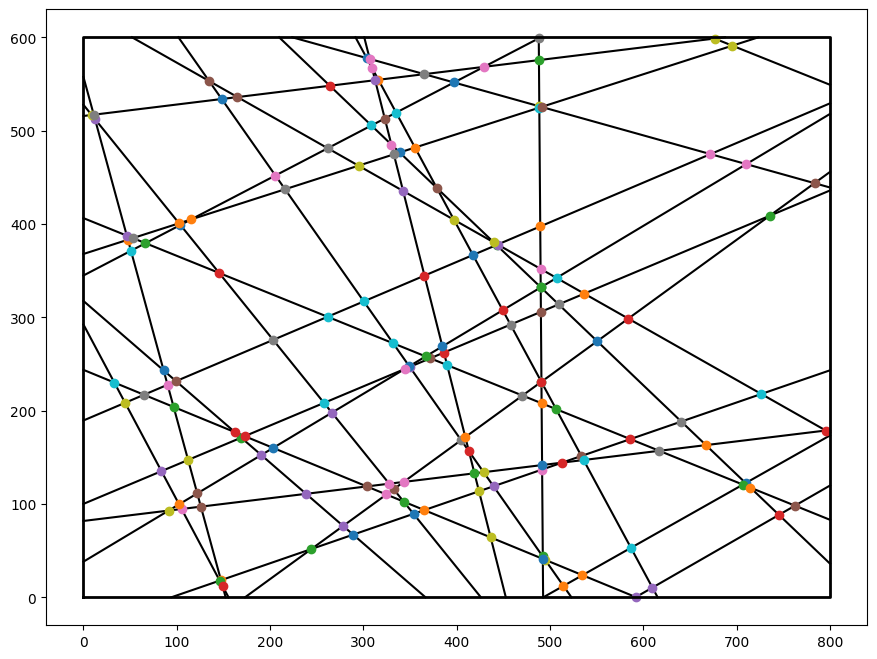

In [407]:
np.random.seed(1)
w = 800
h = 600
num_lines = 25
css_colors = colors.CSS4_COLORS
colors_keys = list(css_colors.keys())

rect = Rectangle(w, h, margin=25)
two_points_set = rect.get_n_num_of_random_two_points(num_lines)

for two_points in two_points_set:
    plt.plot([p[0] for p in two_points], [p[1] for p in two_points], color='k')


lines_set = [Line(two_points=two_points) for two_points in two_points_set]
inter = Intersection(lines_set, w, h)

unique_intersection_points = inter.unique_intersection_points

for p in unique_intersection_points:
    plt.plot(p[0], p[1], 'o')

plt.plot(rect.critical_all_x, rect.critical_all_y, color='k', linewidth=2)
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches((13,8))
plt.show()

## Now we'll try to expermient with random paths on the given plot

There are several ways to work with random path:

1) We select a random line, among all lines, we find the closest intersection. It will be with only one line (highly probably). Then we can chose either turn 'right' or turn 'left' and then we repeat the procedure for a given number of times or until the line reaches the border
2) We can find not the closest intersection, but also randomly - by index.
3) We can define the rules like: 'turn 3 times left, then 3 times right, then 2 times left, 2 times right'. Though it requires understanding what is right and what is left.
4) We can do while operator, so the line searchs for a path that is at least >= n;
5) From a given point we can actually obtain all the possible lines. On each intersection we add 2 closes possibilities. In the end we have different path points with different lengths

{'start': (0, 100.05037411337676), 9d558f0b-90fc-498a-a8ee-9b9b7537a47a: (112.16071712172212, 147.1391626056256), bd9aac7f-ecb8-4367-8f0c-da1b33cdcbf5: (169.06207783346065, 171.02824078054834), e1b6368a-0d5b-4bd9-a46f-9c7114d1bd4d: (257.7523912330776, 208.26337547082932), 71f4b547-8375-41b6-a926-b6242d01fd39: (349.6143900291823, 246.83008886916252), 25298240-eda6-4026-a005-fcce54688582: (386.2667303728536, 262.21795680082005), d200917c-db7e-46b6-933e-5c5d5514e096: (457.5796324942633, 292.1574779713136), 7fe86a27-2883-494e-aea4-97784780fdeb: (490.14409957170403, 305.8291211448159), 2ae80e0f-39b5-4aa6-8690-5f97300f23a7: (509.17186925212206, 313.8176098506085), cb7ac742-8af1-41c6-bd86-f055b996a043: (536.6096726437248, 325.3369095997083), b3d31021-5a13-4166-8edd-529205f9b010: (735.2325153204318, 408.7253656344754), 'end': (800, 435.91690350545156)}
[(0, 100.05037411337676), (112.16071712172212, 147.1391626056256), (169.06207783346065, 171.02824078054834), (257.7523912330776, 208.2633754708

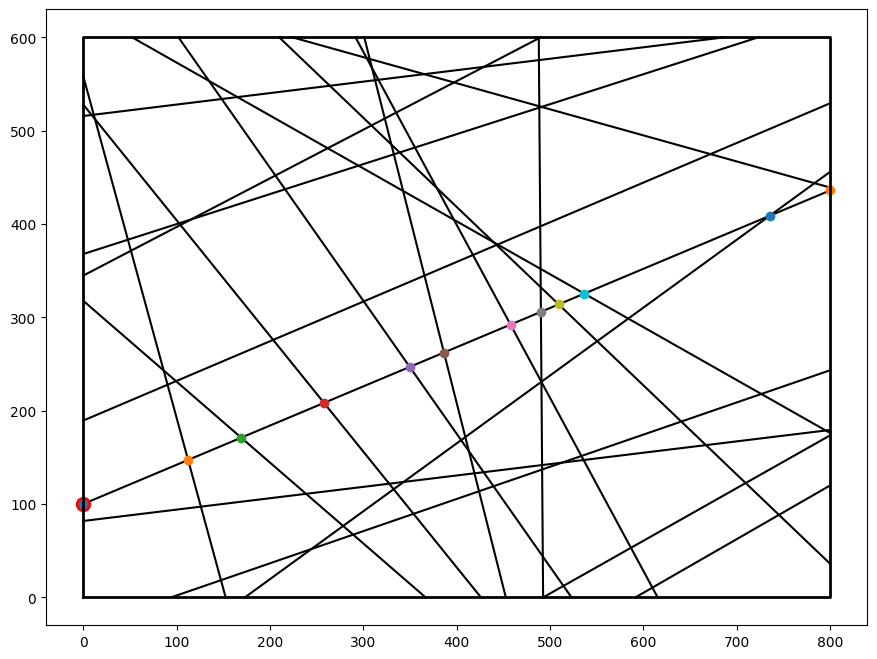

In [454]:
np.random.seed(1)
w = 800
h = 600
num_lines = 20
path_steps = 5
css_colors = colors.CSS4_COLORS
colors_keys = list(css_colors.keys())

rect = Rectangle(w, h, margin=25)
two_points_set = rect.get_n_num_of_random_two_points(num_lines)

for two_points in two_points_set:
    plt.plot([p[0] for p in two_points], [p[1] for p in two_points], color='k')


lines_set = [Line(two_points=two_points) for two_points in two_points_set]
inter = Intersection(lines_set, w, h)
intersections_by_line = inter.intersections
intersections_coords = inter.ordered_intersections_coords
interseciton_keys = inter.ordered_intersections_line_keys


cur_line = np.random.choice(lines_set)
start_point = cur_line.start if np.random.rand() > 0.5 else cur_line.end

# Drawing the starting point
plt.plot(start_point[0], start_point[1], 'o', color='r', markersize=10)

print(intersections_by_line[cur_line])
print(inter.ordered_intersections_coords[cur_line])
print(interseciton_keys)
for line, point in intersections_by_line[cur_line].items():
    plt.plot(point[0], point[1], 'o')


plt.plot(rect.critical_all_x, rect.critical_all_y, color='k', linewidth=2)
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches((13,8))
plt.show()

In [432]:
a = ((1,1), (10,10), (20,20), (666, 666))

a.index((10,10))

1